# Summary

## Task

To explore dependency parsing for sentences so that word level graphs can be constructed for the problem of classification

1. Explore how dependency parsing works
2. Tokenize sentences and give them to the dependency parser
3. Obtain the relationships and check them
4. Convert the dependency graphs from the parser into the graphs that can be used for GCN
5. Explore GCN and try to build graphs from the parsed dependency graphs
6. Perform graph level classification
7. Check performance
8. Refine the various layers and hyperparameters in the process
9. Check final performance
10. Do interpreation manually on some selected examples
11. Implement edge masking to get the minimum subgraph
12. Performe automatic interpretation of the graphs to determine the most important terms/relationships for each sentence

## Method

* For dependency parsing, we will try to use the tools from the stanford nlp group.
* The *[CoreNLP](https://github.com/stanfordnlp/CoreNLP)* library is important as it contains many of the tools needed to performe dependency parsing
* The *[stanza](https://github.com/stanfordnlp/stanza)* library offers a wrapped version of CoreNLP that works directly with Python
* Visualization of the graphs can be done using *[networkx](https://github.com/networkx/networkx)*
* For GCN and word-level graphs we will primarily look at the ideas in this *[tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial7/GNN_overview.html)*
* We will try to use the *[spektral](https://github.com/danielegrattarola/spektral/)* library to implement the graphs convolution and attention 
* *[Link](https://universaldependencies.org/u/dep/)* to explaination of dependency relations.

## Dataset

The dataset is still IMDB review but we may expand later on

## Results

Fill in later

## Conclusion

Fill in at the end

# Code

## Basic Imports

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
import stanza

In [32]:
stanza.download('en')

INFO:stanza:Downloading default packages for language: en (English)...
INFO:stanza:File exists: /Users/zeyuyang/stanza_resources/en/default.zip
INFO:stanza:Finished downloading models and saved to /Users/zeyuyang/stanza_resources.


In [33]:
import networkx as nx
import spacy

## Part 1: Dependency Parsing

### Testing Stanza

In [157]:
sampleSentence = "There is nothing wrong with Apple's new M1 Max Chip, everything works so well!"

In [158]:
sampleSentence

"There is nothing wrong with Apple's new M1 Max Chip, everything works so well!"

In [155]:
nlp = stanza.Pipeline(
    'en',
    processors = 'tokenize,mwt,pos,lemma,depparse')

INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!


In [159]:
doc = nlp(sampleSentence)

In [160]:
doc

[
  [
    {
      "id": 1,
      "text": "There",
      "lemma": "there",
      "upos": "PRON",
      "xpos": "EX",
      "head": 2,
      "deprel": "expl",
      "start_char": 0,
      "end_char": 5
    },
    {
      "id": 2,
      "text": "is",
      "lemma": "be",
      "upos": "VERB",
      "xpos": "VBZ",
      "feats": "Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin",
      "head": 0,
      "deprel": "root",
      "start_char": 6,
      "end_char": 8
    },
    {
      "id": 3,
      "text": "nothing",
      "lemma": "nothing",
      "upos": "PRON",
      "xpos": "NN",
      "feats": "Number=Sing",
      "head": 2,
      "deprel": "nsubj",
      "start_char": 9,
      "end_char": 16
    },
    {
      "id": 4,
      "text": "wrong",
      "lemma": "wrong",
      "upos": "ADJ",
      "xpos": "JJ",
      "feats": "Degree=Pos",
      "head": 3,
      "deprel": "amod",
      "start_char": 17,
      "end_char": 22
    },
    {
      "id": 5,
      "text": "with",
      "lemma":

In [161]:
doc.sentences[0].print_dependencies()

('There', 2, 'expl')
('is', 0, 'root')
('nothing', 2, 'nsubj')
('wrong', 3, 'amod')
('with', 10, 'case')
('Apple', 10, 'nmod:poss')
("'s", 6, 'case')
('new', 10, 'amod')
('M1', 10, 'compound')
('Max', 3, 'nmod')
('Chip', 10, 'flat')
(',', 14, 'punct')
('everything', 14, 'nsubj')
('works', 2, 'parataxis')
('so', 16, 'advmod')
('well', 14, 'advmod')
('!', 2, 'punct')


In [235]:
sent_dict = doc.sentences[0].to_dict()

#### tokenRelationHead

In [236]:
def tokenRelationHead(sent_dict):
    """
    Prints the token - relation - head chart
    Args:
        sent_dict - (list) The dictionary from sentence.to_dict()
    Returns:
        
    """
    
    print ("{:<15} | {:<10} | {:<15} ".format('Token', 'Relation', 'Head'))
    print ("-" * 50)

    # iterate to print the token, relation and head
    for word in sent_dict:
      print ("{:<15} | {:<10} | {:<15} ".format(
          str(word['text']),
          str(word['deprel']),
          str(sent_dict[word['head']-1]['text'] if word['head'] > 0 else 'ROOT')))

In [237]:
tokenRelationHead(sent_dict)

Token           | Relation   | Head            
--------------------------------------------------
There           | expl       | is              
is              | root       | ROOT            
nothing         | nsubj      | is              
wrong           | amod       | nothing         
with            | case       | Max             
Apple           | nmod:poss  | Max             
's              | case       | Apple           
new             | amod       | Max             
M1              | compound   | Max             
Max             | nmod       | nothing         
Chip            | flat       | Max             
,               | punct      | works           
everything      | nsubj      | works           
works           | parataxis  | is              
so              | advmod     | well            
well            | advmod     | works           
!               | punct      | is              


#### drawDepGraph

In [268]:
def drawDepGraph(sent_dict, edgeList):
    """
    Draws the dependency graph for a sentence. The words are nodes and the edges are th e
    """
    
    G = nx.DiGraph()
    G.add_nodes_from(range(1, len(sent_dict) + 1))
    nodeLabels = dict((node['id'], str(node['id']) + " : " + node['text']) for node in sent_dict)
    
    edgeLabels = []
    for edge in edgeList:
        G.add_edge(*edge['edgePair'])
        edgeLabels.append((edge['edgePair'], edge['edgeLabel']))
    
    edgeLabels = dict(edgeLabels)

    plt.figure(3,figsize=(12,12)) 
    pos = nx.spring_layout(G)

    nx.draw(G, pos, with_labels=True, labels=nodeLabels, node_size=2000, node_color='#B5EAD7', font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edgeLabels, font_size=8)
    plt.show()

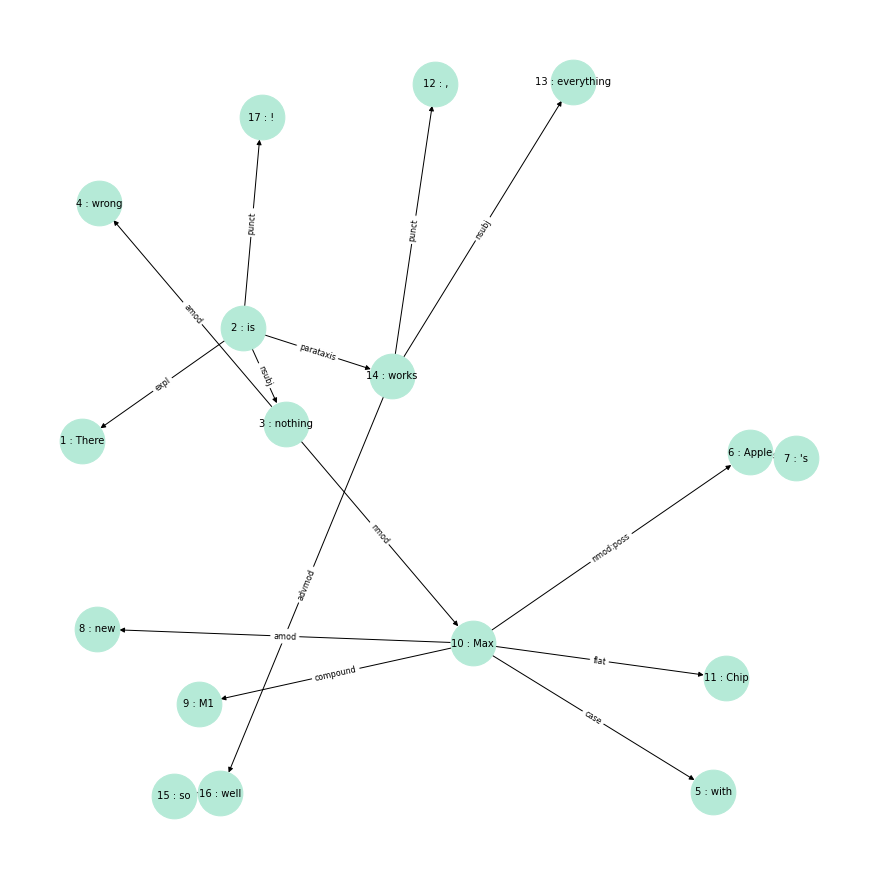

In [269]:
sent_dict = doc.sentences[0].to_dict()
edgeList = getEdgeDictsList(sent_dict)
drawDepGraph(sent_dict, edgeList)

In [257]:
sent_dict

[{'id': 1,
  'text': 'There',
  'lemma': 'there',
  'upos': 'PRON',
  'xpos': 'EX',
  'head': 2,
  'deprel': 'expl',
  'start_char': 0,
  'end_char': 5},
 {'id': 2,
  'text': 'is',
  'lemma': 'be',
  'upos': 'VERB',
  'xpos': 'VBZ',
  'feats': 'Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin',
  'head': 0,
  'deprel': 'root',
  'start_char': 6,
  'end_char': 8},
 {'id': 3,
  'text': 'nothing',
  'lemma': 'nothing',
  'upos': 'PRON',
  'xpos': 'NN',
  'feats': 'Number=Sing',
  'head': 2,
  'deprel': 'nsubj',
  'start_char': 9,
  'end_char': 16},
 {'id': 4,
  'text': 'wrong',
  'lemma': 'wrong',
  'upos': 'ADJ',
  'xpos': 'JJ',
  'feats': 'Degree=Pos',
  'head': 3,
  'deprel': 'amod',
  'start_char': 17,
  'end_char': 22},
 {'id': 5,
  'text': 'with',
  'lemma': 'with',
  'upos': 'ADP',
  'xpos': 'IN',
  'head': 10,
  'deprel': 'case',
  'start_char': 23,
  'end_char': 27},
 {'id': 6,
  'text': 'Apple',
  'lemma': 'Apple',
  'upos': 'PROPN',
  'xpos': 'NNP',
  'feats': 'Number=Sing

#### getEdgeDictsList

In [232]:
def getEdgeDictsList(sent_dict):
    """
    Parses all the edges in sent_dict and extracts the edges, node labels, and edge labels.
    Args:
        sent_dict - (list) The dictionary from sentence.to_dict()
    Returns:
        edgeList - (list) A list of dictionaries, the keys are "edgePair", "nodeLabels", "edgeLabel"
    """
    edgeList = []
    for edge in sent_dict:
        if edge['head']:
            edgePair = (edge['head'], edge['id'])
            nodeLabels = (sent_dict[edge['head'] - 1]['text'], edge['text'])
            edgeLabel = edge['deprel']
            edgeList.append(
                {
                    "edgePair" : edgePair,
                    "nodeLabels" : nodeLabels,
                    "edgeLabel" : edgeLabel,
                }
            )
    return edgeList

In [233]:
getEdgeDictsList(sent_dict)

[{'edgePair': (2, 1), 'nodeLabels': ('is', 'There'), 'edgeLabel': 'expl'},
 {'edgePair': (2, 3), 'nodeLabels': ('is', 'nothing'), 'edgeLabel': 'nsubj'},
 {'edgePair': (3, 4), 'nodeLabels': ('nothing', 'wrong'), 'edgeLabel': 'amod'},
 {'edgePair': (10, 5), 'nodeLabels': ('Max', 'with'), 'edgeLabel': 'case'},
 {'edgePair': (10, 6),
  'nodeLabels': ('Max', 'Apple'),
  'edgeLabel': 'nmod:poss'},
 {'edgePair': (6, 7), 'nodeLabels': ('Apple', "'s"), 'edgeLabel': 'case'},
 {'edgePair': (10, 8), 'nodeLabels': ('Max', 'new'), 'edgeLabel': 'amod'},
 {'edgePair': (10, 9), 'nodeLabels': ('Max', 'M1'), 'edgeLabel': 'compound'},
 {'edgePair': (3, 10), 'nodeLabels': ('nothing', 'Max'), 'edgeLabel': 'nmod'},
 {'edgePair': (10, 11), 'nodeLabels': ('Max', 'Chip'), 'edgeLabel': 'flat'},
 {'edgePair': (14, 12), 'nodeLabels': ('works', ','), 'edgeLabel': 'punct'},
 {'edgePair': (14, 13),
  'nodeLabels': ('works', 'everything'),
  'edgeLabel': 'nsubj'},
 {'edgePair': (2, 14),
  'nodeLabels': ('is', 'works')

In [226]:
sent_dict[2]

{'id': 3,
 'text': 'nothing',
 'lemma': 'nothing',
 'upos': 'PRON',
 'xpos': 'NN',
 'feats': 'Number=Sing',
 'head': 2,
 'deprel': 'nsubj',
 'start_char': 9,
 'end_char': 16}

### Testing Spacy (Ignore for Now)

In [29]:
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

# Process whole documents
text = sampleSentence
doc = nlp(text)
# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)

    

NameError: name 'sampleSentence' is not defined

In [135]:
spacy.displacy.render(doc, style='dep', jupyter=True, options={'distance': 120})

In [141]:
doc.

There is nothing wrong with Apple's new M1 Max Chip, everything works so well!

### Testing TF Datasets

In [84]:
import tensorflow_datasets as tfds
import tensorflow as tf
import spacy
nlp = spacy.load("en_core_web_sm")

In [88]:
trainDS = tfds.load('imdb_reviews', split='train', as_supervised=True, shuffle_files=True)
testDS = tfds.load('imdb_reviews', split='test', as_supervised=True, shuffle_files=True)

In [89]:
part = testDS.take(2)

#### decodeZeroDimTensor

In [144]:
def decodeZeroDimTensor(yourTensor):
    """
    Takes a tensor of zero dim and returns the string stored inside
    Args:
        yourTensor - (tf.Tensor) The input tensor you want to convert
    Returns:
        yourString - (string) The string from the decoded tensor
    """
    noSpecial = tf.strings.regex_replace(
        yourTensor,
        "<[^>]+>",
        " ")
    return np.array(noSpecial).reshape((1,))[0].decode("utf-8") 

#### convertTakeDataset

In [145]:
def convertTakeDataset(takeDataset):
    """
    Converts your takeDataset into features and labels
    Args:
        takeDataset - (TakeDataset) the TakeDataset that contains some number of examples from your initial dataset
    Returns:
        features - (list) the list of features
        labels - (list) the list of labels
    """
    labels = []
    features = []
    for text, label in takeDataset:
        labels.append(int(np.array(label)))
        features.append(decodeZeroDimTensor(text))

    return features, labels

In [146]:
features, labels = convertTakeDataset(part)

2022-05-24 21:14:49.659783: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [147]:
len(features)

2

In [148]:
features

["There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.",
 "A blackly comic tale of a down-trodden priest, Nazarin

In [149]:
labels

[1, 1]

In [121]:
nlp = stanza.Pipeline(
    'en',
    processors = 'tokenize,mwt,pos,lemma,depparse, sentiment')

INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |
| sentiment | sstplus  |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Done loading processors!


In [152]:
doc = nlp(features[1])

In [153]:
for sentence in doc.sentences:
    print(sentence.text)
    print(sentence.sentiment)

A blackly comic tale of a down-trodden priest, Nazarin showcases the economy that Luis Bunuel was able to achieve in being able to tell a deeply humanist fable with a minimum of fuss.
2
As an output from his Mexican era of film making, it was an invaluable talent to possess, with little money and extremely tight schedules.
2
Nazarin, however, surpasses many of Bunuel's previous Mexican films in terms of the acting (Francisco Rabal is excellent), narrative and theme.
2
The theme, interestingly, is something that was explored again in Viridiana, made three years later in Spain.
1
It concerns the individual's struggle for humanity and altruism amongst a society that rejects any notion of virtue.
1
Father Nazarin, however, is portrayed more sympathetically than Sister Viridiana.
1
Whereas the latter seems to choose charity because she wishes to atone for her (perceived) sins, Nazarin's whole existence and reason for being seems to be to help others, whether they (or we) like it or not.
1
T

In [270]:
doc.sentences[0].print_dependencies()

('There', 2, 'expl')
('is', 0, 'root')
('nothing', 2, 'nsubj')
('wrong', 3, 'amod')
('with', 10, 'case')
('Apple', 10, 'nmod:poss')
("'s", 6, 'case')
('new', 10, 'amod')
('M1', 10, 'compound')
('Max', 3, 'nmod')
('Chip', 10, 'flat')
(',', 14, 'punct')
('everything', 14, 'nsubj')
('works', 2, 'parataxis')
('so', 16, 'advmod')
('well', 14, 'advmod')
('!', 2, 'punct')


## Part 2: Graph Networks

### Basic Imports

In [274]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stanza
import networkx as nx
import tensorflow_hub as hub
import tensorflow_text
# import spectral

### Load Data

In [273]:
trainDS = tfds.load('imdb_reviews', split='train', as_supervised=True, shuffle_files=True)
testDS = tfds.load('imdb_reviews', split='test', as_supervised=True, shuffle_files=True)

#### Set a Limit

In [360]:
trainLimit = 4000
testLimit = 4000

trainSubset = trainDS.take(trainLimit)
testSubset = testDS.take(testLimit)

In [361]:
validationSplit = 0.5
validationIndex = int(validationSplit * trainLimit)

validationSplitSubset = trainSubset.take(validationIndex)
trainSplitSubset = trainSubset.skip(validationIndex)

In [362]:
trainFeatures, trainLabels = convertTakeDataset(trainSplitSubset)
valFeatures, valLabels = convertTakeDataset(validationSplitSubset)
testFeatures, testLabels = convertTakeDataset(testSubset)

2022-05-24 23:42:46.405591: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


#### Bert Embeddings

In [313]:
tf.keras.backend.clear_session()

In [314]:
# Preprocess and encode input
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
encoder_inputs = preprocessor(text_input)

encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2',trainable=False)

outputs = encoder(encoder_inputs)

pooled_output = outputs['pooled_output'] # [batch_size, 128].
# [batch_size, seq_length, 128].

sequence_output = outputs['sequence_output']

2022-05-24 23:03:59.345773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-24 23:03:59.812630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [372]:
def sampleModel():
    inputs = text_input
    preprocessorLayer = preprocessor(inputs)['input_word_ids']
    
    embedding_layer = tf.keras.layers.Embedding(10000,
                                                128)(preprocessorLayer)
    # embedding_layer = encoder(preprocessorLayer)['pooled_output']
    
    flatten = tf.keras.layers.Flatten()(embedding_layer)
    dense_layer = tf.keras.layers.Dense(16, activation='relu')(flatten)
    outputs = tf.keras.layers.Dense(1)(dense_layer)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [373]:
tf.keras.backend.clear_session()
model = sampleModel()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    {'input_mask': (None, 12  0         
                             8),                                 
                              'input_word_ids': (None            
                             , 128),                             
                              'input_type_ids': (None            
                             , 128)}                             
                                                                 
 embedding (Embedding)       (None, 128, 128)          1280000   
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                             

In [374]:
model.compile(
    optimizer='rmsprop',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [375]:
history = model.fit(
    trainFeatures,
    trainLabels,
    validation_data=(valFeatures, valLabels),
    epochs=20,
    verbose=1)

Epoch 1/20


2022-05-24 23:55:12.877853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.4940

2022-05-24 23:55:22.030819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 17s 263ms/step - loss: 0.6855 - accuracy: 0.4940 - val_loss: 0.6798 - val_accuracy: 0.5530
Epoch 2/20
63/63 [==============================] - 15s 245ms/step - loss: 0.3528 - accuracy: 0.8875 - val_loss: 0.6370 - val_accuracy: 0.6275
Epoch 3/20
63/63 [==============================] - 16s 257ms/step - loss: 0.0629 - accuracy: 0.9930 - val_loss: 0.6750 - val_accuracy: 0.6275
Epoch 4/20
63/63 [==============================] - 16s 264ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.7958 - val_accuracy: 0.6645
Epoch 5/20
63/63 [==============================] - 17s 272ms/step - loss: 6.8266e-04 - accuracy: 1.0000 - val_loss: 0.8110 - val_accuracy: 0.6785
Epoch 6/20
63/63 [==============================] - 17s 271ms/step - loss: 6.2386e-05 - accuracy: 1.0000 - val_loss: 0.9599 - val_accuracy: 0.6745
Epoch 7/20
63/63 [==============================] - 17s 280ms/step - loss: 5.4562e-06 - accuracy: 1.0000 - val_loss: 0.9933 - val_accuracy: 0.684

KeyboardInterrupt: 

In [367]:
results = model.evaluate(x=testFeatures, y=testLabels)
print(results)

2022-05-24 23:50:55.919001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 24s 185ms/step - loss: 0.6193 - accuracy: 0.6163
[0.6193355917930603, 0.6162500381469727]


### Convert Data to Graph Format

### Model and Training

### Evaluation